## Reproductible fitting

In [2]:
from typing import Any, cast

import matplotlib.pyplot as plt
import torch

import jmstate
from jmstate import MultiStateJointModel
from jmstate.jobs import LogParamsHistory, RandomFit
from jmstate.typedefs import HazardFns, ModelData, ModelDesign, ModelParams, SampleData
from jmstate.utils import repr_from_cov

In [3]:
torch.manual_seed(123)  # type: ignore


def sigmoid(t: torch.Tensor, psi: torch.Tensor):
    scale, offset, slope = psi.chunk(3, dim=-1)
    return (scale * torch.sigmoid((t - offset) / slope)).unsqueeze(-1)


def f(gamma: torch.Tensor | None, x: torch.Tensor | None, b: torch.Tensor):
    psi = cast(torch.Tensor, gamma) + b
    psi[..., [0, 2]].exp_()
    return psi


def random_far_apart(
    n: int, m: int, a: torch.Tensor, b: torch.Tensor, min_dist: torch.Tensor
):
    L_free = (b - a) - (m - 1) * min_dist

    y = torch.rand(n, m) * L_free
    y, _ = torch.sort(y, dim=1)

    gap_offset = torch.arange(m) * min_dist

    return a + y + gap_offset

In [4]:
def plot_history(
    vals: list[torch.Tensor], true_val: torch.Tensor, name: str, colors: list[Any]
):
    plt.plot(torch.cat(vals, dim=0))  # type: ignore

    for i, t in enumerate(true_val):
        plt.axhline(  # type: ignore
            y=t.item(),
            color=colors[i],
            linestyle="--",
            label=(
                f"True value of {name}" + (f"({i + 1})" if true_val.numel() > 1 else "")
            ),
        )

    plt.title(f"Stochastic optimization of the parameter {name}.")  # type: ignore
    plt.legend()  # type: ignore
    plt.xlabel("Iteration")  # type: ignore
    plt.ylabel("Value")  # type: ignore
    plt.tight_layout()


def param_names(params_dict: dict[Any, Any]) -> list[str]:
    names: list[str] = []

    def _rec(node: dict[Any, Any] | torch.Tensor, prefix: list[Any]):
        if isinstance(node, torch.Tensor):
            base_name = str(prefix[0]) + "".join(f"[{item}]" for item in prefix[1:])
            num_elements = node.numel()
            if num_elements <= 1:
                names.append(base_name)
            else:
                names.extend(f"{base_name}[{i + 1}]" for i in range(num_elements))
        else:
            for k, v in node.items():
                prefix.append(k)
                _rec(v, prefix)
                prefix.pop()

    _rec(params_dict, [])

    return names

In [5]:
lmda, k = 12.0, 2.0
weibull_fn = jmstate.functions.Weibull(k, lmda)

gamma = torch.tensor([1.7, 6.0, 1.2])

Q = torch.diag(torch.tensor([0.6, 1.9, 0.3]))
R = torch.tensor([[0.2]])

alphas = {("alive", "dead"): torch.tensor([0.4])}
betas = {("alive", "dead"): torch.tensor([-0.9, 0.8, 0.2])}

real_params = ModelParams(
    gamma,
    repr_from_cov(Q, method="diag"),
    repr_from_cov(R, method="ball"),
    alphas,
    betas,
)

Q_dist = torch.distributions.MultivariateNormal(torch.zeros(3), Q)
R_dist = torch.distributions.MultivariateNormal(torch.zeros(1), R)

In [6]:
model_design = ModelDesign(
    f, sigmoid, {("alive", "dead"): HazardFns(weibull_fn, sigmoid)}
)

In [7]:
real_model = MultiStateJointModel(model_design, real_params)

In [8]:
n, m, p = 500, 15, 3


def gen_data(n: int, m: int, p: int):
    c = torch.rand(n, 1) * 5 + 10
    x = torch.randn(n, p)

    b = Q_dist.sample((n,))
    psi = f(gamma, x, b)

    a = torch.zeros((n, 1))
    t = random_far_apart(n, m, a, c, 0.7 * c / m)

    trajectories_init = [[(0.0, "alive")] for _ in range(n)]
    sample_data = SampleData(x, trajectories_init, psi)
    trajectories = real_model.sample_trajectories(sample_data, c)

    y = model_design.regression_fn(t, psi).squeeze(0)
    y += R_dist.sample(y.shape[:2])
    y[t > c] = torch.nan

    return x, t, y, trajectories, c

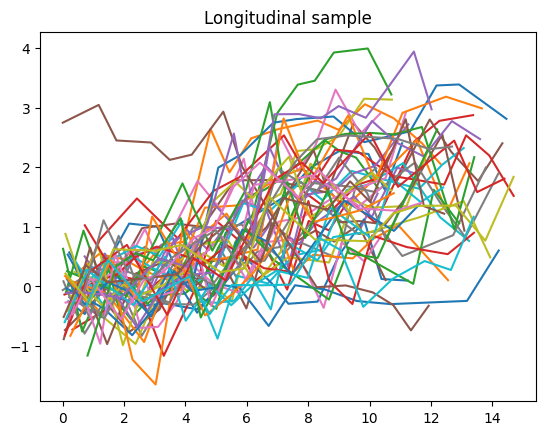

In [9]:
x, t, y, trajectories, c = gen_data(n, m, p)

plt.plot(t[:50].T, y[:50].squeeze(-1).T)  # type: ignore
plt.title("Longitudinal sample")  # type: ignore
plt.show()  # type: ignore

In [10]:
init_params = ModelParams(
    torch.zeros_like(gamma),
    repr_from_cov(torch.eye(Q.size(0)), method="diag"),
    repr_from_cov(torch.eye(R.size(0)), method="full"),
    {k: torch.zeros_like(v) for k, v in alphas.items()},
    {k: torch.zeros_like(v) for k, v in betas.items()},
)

data = ModelData(x, t, y, trajectories, c)

In [ ]:
model = MultiStateJointModel(model_design, init_params)
metrics = model.do(
    data,
    job_factories=[
        RandomFit(lr=0.1),
        LogParamsHistory(),
    ],
    max_iterations=500,
    n_steps=10,
)

Running joint model: 100%|██████████| 500/500 [00:11<00:00, 42.74it/s]


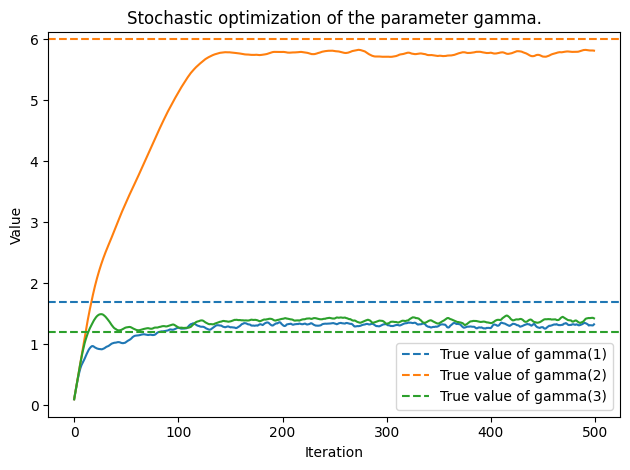

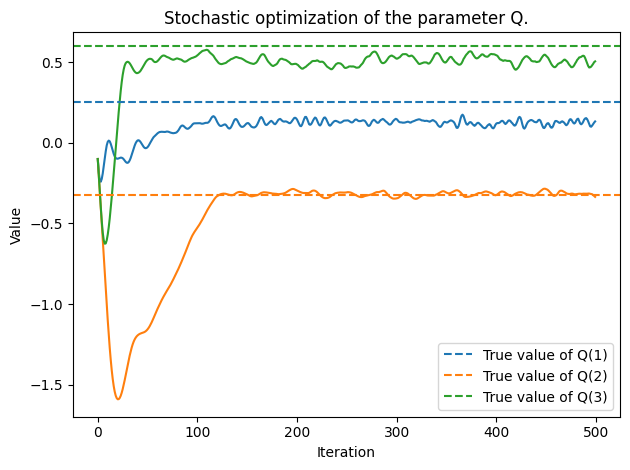

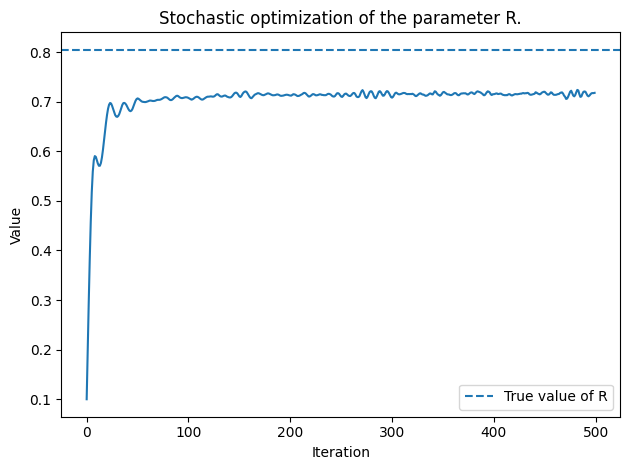

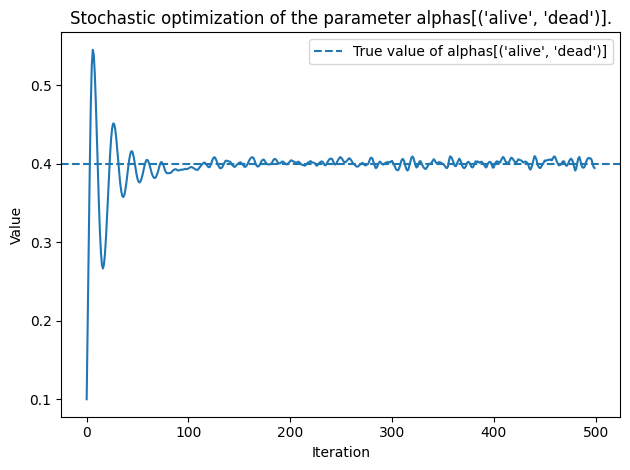

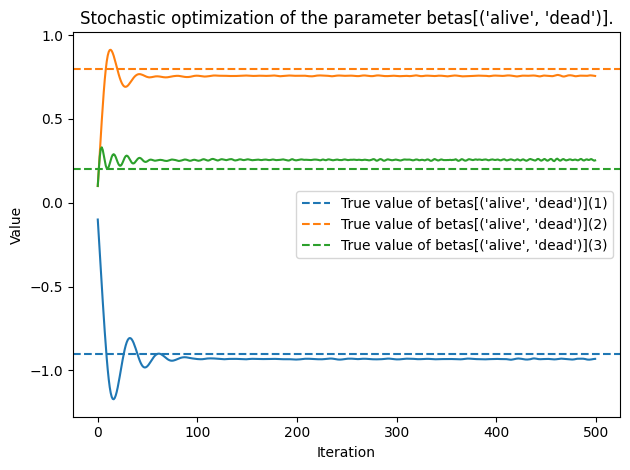

In [12]:
params_dict = model.params_.as_dict
real_params_dict = real_model.params_.as_dict
colors: list[Any] = cast(list[Any], plt.get_cmap("tab10").colors)  # type: ignore

for key, val in params_dict.items():
    if isinstance(val, torch.Tensor):
        history = [
            cast(torch.Tensor, p.as_dict[key])[None]
            for p in cast(list[ModelParams], metrics)
        ]
        plot_history(history, cast(torch.Tensor, real_params_dict[key]), key, colors)
        plt.savefig(f"figures/{key}.png")  # type: ignore
        plt.show()  # type: ignore
    else:
        for subkey in val:
            history = [p.as_dict[key][subkey][None] for p in metrics]  # type: ignore
            plot_history(
                history,  # type: ignore
                real_params_dict[key][subkey],
                key + f"[{subkey}]",
                colors,
            )
            plt.savefig(f"figures/{key}_{subkey}.png")  # type: ignore
            plt.show()  # type: ignore